In [1]:
import GPy
from GPy.inference.optimization import Optimizer
%matplotlib inline

## Implementing a new optimizer

Though GPy contains many inbuilt optimisers, including many of those implemented within scipy, there are cases where optimisers that have not yet been implemented within GPy could aid the optimisation of certain models. For example in recent years there has been an explosion of interest in stochastic methods of optimisation, where only approximate gradients are required. Many default optimisers cannot allow for this situation, and many new and effective optimisers have been proposed. It would be neat if we were able to implement new optimisers easily and still make use of the GPy framework for the rest of model development.

In Paramz/GPy we can implement an own optimizer in a very simple way. We simply need to supply GPy with an implementation of the Optimizer class, and the rest will be handled automatically.

The Optimizer has a `opt_name` parameter, which is the important and should not be shared with any other optimizers.

It also must provide an implementation of the `opt()` method, which opitmizes the result given an optimization function and a starting point.

We will illustrate the implementation of a new optimiser for GPy using an external package containing many optimisers called `climin`. Specifically we will integrate the "Rprop" optimiser for use in GPy.

In [2]:
import climin

In [3]:
# Get the parameters for Rprop of climin:
climin.Rprop?

Simply inherit from the `GPy.inference.optimization.Optimizer` class, provide a instance variable `opt_name`, and implement the `opt` method to make steps in the optimisation, in order to find the modal value of the log marginal likelihood.

In [4]:
class RProp(Optimizer):
    """
    Rprop implementation from climin
    """
    # We want the optimizer to know some things in the Optimizer implementation:
    def __init__(self, step_shrink=0.5, step_grow=1.2, min_step=1e-06, max_step=1, changes_max=0.1, *args, **kwargs):
        super(RProp, self).__init__(*args, **kwargs)
        self.opt_name = 'RProp (climin)'
        self.step_shrink = step_shrink
        self.step_grow = step_grow
        self.min_step = min_step
        self.max_step = max_step
        self.changes_max = changes_max
        
    def opt(self, x_init, f_fp=None, f=None, fp=None):
        """
        :param x_init: current parameter values in an np.ndarray (num_parameters)
        :param f_fp: function for evalating the log_likelihood at the current parameters and
                     its gradients wrt to the parameters
        :param f: function for evaluating the log_likelihood with the current parameters
        :param fp: function for evaluating gradient the log_likelihood with teh current parameters,
                   wrt the all the parameters
        """
        # We only need the gradient of the log likelihood, but this must be provided
        assert not fp is None

        # Do the optimization, giving previously stored parameters
        opt = climin.rprop.Rprop(x_init, fp, 
                                 step_shrink=self.step_shrink, step_grow=self.step_grow, 
                                 min_step=self.min_step, max_step=self.max_step, 
                                 changes_max=self.changes_max)

        # Get the optimized state and transform it into Paramz readable format by setting
        # values on this object:
        # Important ones are x_opt and status:
        for info in opt:
            if info['n_iter']>=self.max_iters:
                self.x_opt =  opt.wrt
                self.status = 'maximum number of function evaluations exceeded'
                break

This is all we need to implement, GPy/Paramz will handle the rest for you. Lets consider an example:

In [5]:
m = GPy.examples.regression.toy_rbf_1d_50(optimize=False, plot=False)

This is the model plot before optimization:

In [6]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


 /Users/alansaul/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


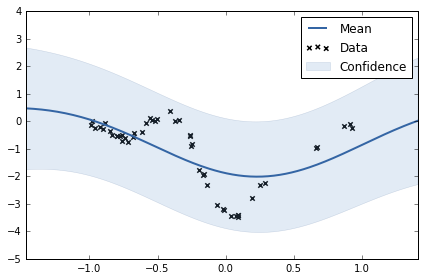

In [7]:
m.plot()

In [8]:
m.optimize(RProp(), messages=1)

And then the optimized state after running RProp:

In [9]:
m

GP_regression.,value,constraints,priors
rbf.variance,2.21219137396,+ve,
rbf.lengthscale,0.271867056443,+ve,
Gaussian_noise.variance,0.0107328329112,+ve,


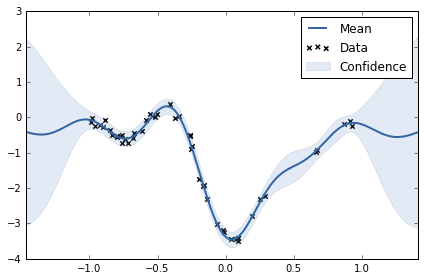

In [10]:
m.plot()